# クレジットカードの債務不履行を予測するモデルの作成
### 評価指標
#### f２スコア:
Precision(債務不履行になると判断されたもののうち実際に債務不履行であるものの割合)よりもrecall(実際に債務不履行であるもののうち債務不履行と予測された割合=損失の大きい債務不履行になる人の取りこぼしを少なくする)を重視する。それを反映する評価指標がf2スコアであり、メインの評価指標として用いることにする。
$$f2score=\frac{5(precision)(recall)}{4precison+recall}$$
##### log_loss:
債務不履行になる確率を求めることは、それがお金を貸すかどうかの判断材料になるという点で実務上の意味があると考えた。Log_lossはLogarithmic Lossのことで入力は0~1の確率の値をとリ、モデルの精度を評価する指標として優れているためこの評価指標も参考にする。
$$Logloss=−\frac{1}{N}\sum_{i=1}^{N}(y_i\ln (p_i)+(1−y_i)\ln(1−p_i))$$

#### ※XGBoost, LightGBMがインストール済みの環境で実行してください

In [93]:
#基本

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#前処理
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#オーバーサンプリング
from imblearn.over_sampling import SMOTE
#交差検証
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#特徴量選択
from sklearn.feature_selection import SelectKBest,mutual_info_classif
#アルゴリズム
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
#評価指標
from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, roc_curve

In [94]:
#データの読み込み
df = pd.read_csv("application_data.csv")
pre_df = pd.read_csv("previous_application.csv")
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## EDA(探索的データ解析)

In [95]:
#データについて確認
print(f"データの大きさ: {df.shape}")
print("--目的変数の内容-------------------")
print(df.TARGET.value_counts())
print("--何の型の変数が何個あるのかを確認----")
print(df.dtypes.value_counts())

データの大きさ: (307511, 122)
--目的変数の内容-------------------
0    282686
1     24825
Name: TARGET, dtype: int64
--何の型の変数が何個あるのかを確認----
float64    65
int64      41
object     16
dtype: int64


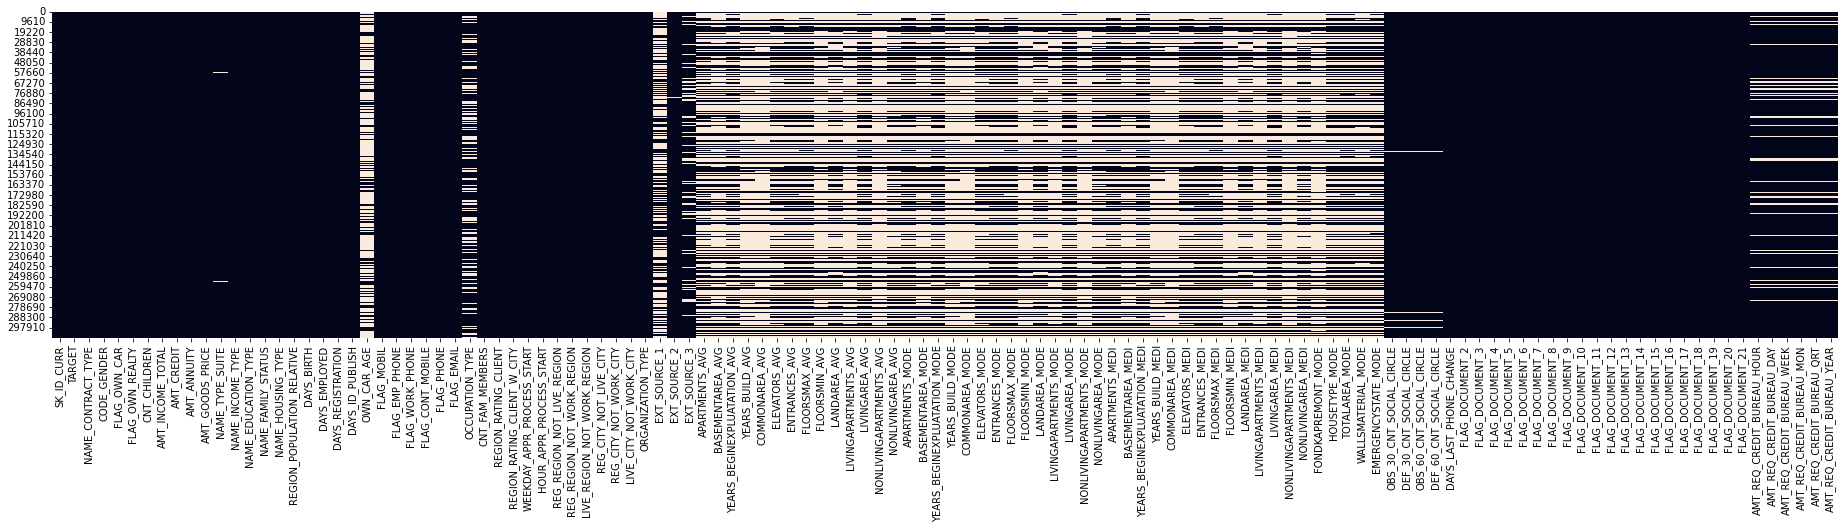

In [96]:
#欠損値の分布を確認
plt.figure(figsize=(32,6))#サイズ調整
sns.heatmap(df.isnull(), cbar=False); #ヒートマップ表示

##### ・クライアントの住宅情報(APARTMENT_AVG~EMERGENCYSTSTE)は欠損値が非常に多く、欠損値の出現が変数によって完全にランダムでないことからデータとして適切ではないと判断したため削除することにする。

In [97]:
#住宅情報を抽出
df_house=df.iloc[:,44:91]
df=df.drop(df_house,axis=1)#住宅情報を削除
df_house.head()#確認のため表示

APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  ...  LANDAREA_MEDI  \
0         0.0833         0.1250        0.0369  ...         0.0375   
1         0.2917         0.3333        0.0130  ...         0.0132   
2            NaN            NaN           NaN  ...            NaN   
3            NaN            NaN           NaN  ...            NaN   
4            NaN            NaN           NaN  ...            NaN   

   LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  \
0                 0.0205           0.0193                    0.0000   
1                 0.0787           0.0558                    0.0039   
2                    NaN              NaN                       NaN   
3                    NaN              NaN                       NaN   
4                    NaN              NaN                       NaN   

   NONLIVINGAREA_MEDI  FONDKAPREMONT_MODE  HOUSETYPE_MODE  TOTALAREA_MODE  \
0                0.00    reg oper account  block of flats          0.0149   
1                0.01    reg oper account  block of flats          0.0714   
2                 NaN                 NaN             NaN             NaN   
3                 NaN                 NaN             NaN             NaN   
4                 NaN                 NaN             NaN             NaN   

   WALLSMATERIAL_MODE  EMERGENCYSTATE_MODE  
0        Stone, brick                   No  
1               Block                   No  
2                 NaN                  NaN  
3                 NaN                  NaN  
4                 NaN                  NaN  

[5 rows x 47 columns]

In [98]:
#改めて確認
print(f"データの大きさ: {df.shape}")
print("--何の型の変数が何個あるのかを確認----")
print(df.dtypes.value_counts())
print("基礎統計量")
print(df.describe().T)

データの大きさ: (307511, 75)
--何の型の変数が何個あるのかを確認----
int64      41
float64    22
object     12
dtype: int64
基礎統計量
                               count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT

In [99]:
#float型の変数名を確認
df_float=df.select_dtypes("float64")
df_float.columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [100]:
#int型の変数名を確認
df_int=df.select_dtypes("int")
df_int.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [101]:
#objct型の変数名を確認
df_obj=df.select_dtypes("object")
df_obj.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

In [102]:
#上の三つから質的変数・量的変数とTARGETによって構成されるデータフレームを作成
#質的変数
int_qual_cols=["CNT_CHILDREN","DAYS_BIRTH","DAYS_EMPLOYED","DAYS_ID_PUBLISH"]#int型の量的データの変数名
df_qual=pd.concat([df_int,df_obj],axis=1)#int型とobject型を結合
df_qual=df_qual.drop(df_qual[int_qual_cols],axis=1)#int型の量的データを削除
df_qual=df_qual.drop("SK_ID_CURR",axis=1)#IDも変数から削除

#量的変数
df_quant=pd.concat([df["TARGET"],df_float,df[int_qual_cols]],axis=1)

### 相関について

<AxesSubplot:>

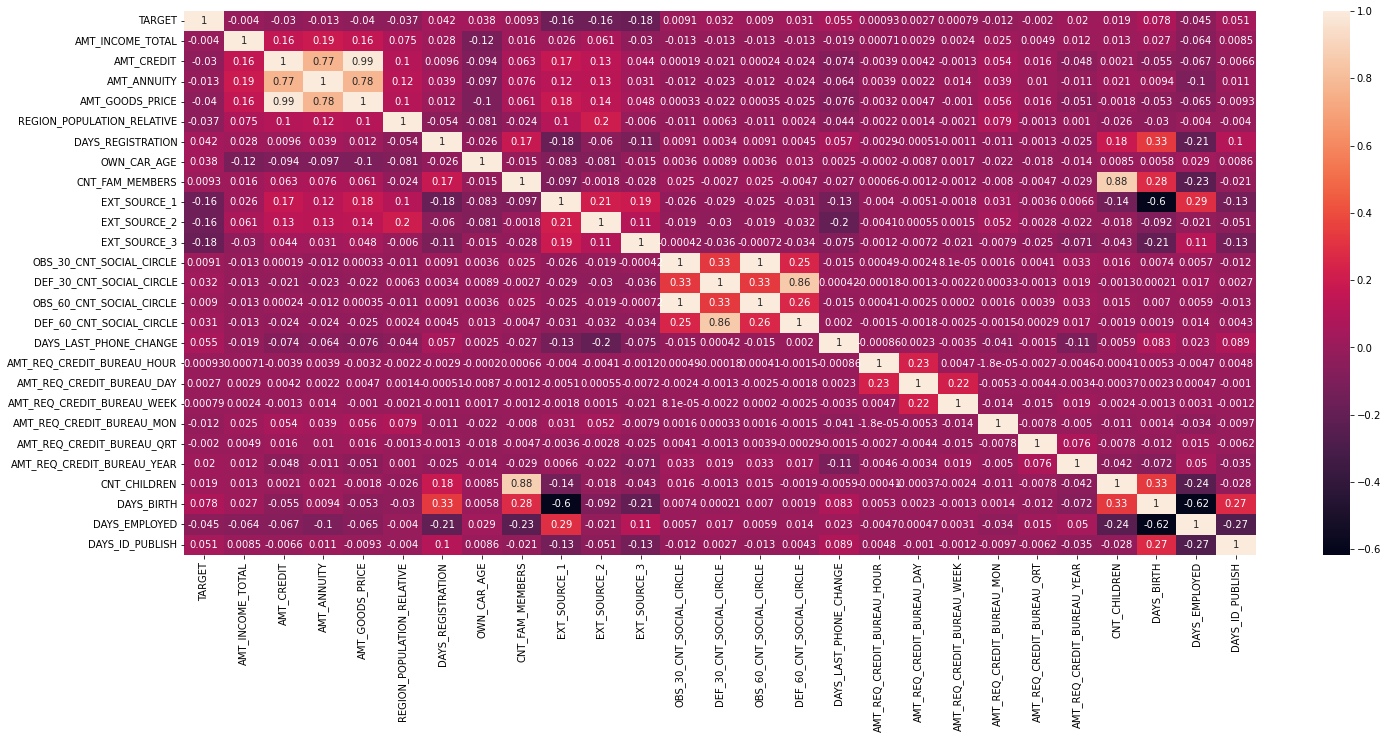

In [103]:
plt.figure(figsize=(24,10))
sns.heatmap(df_quant.corr(),annot=True)

#### ・OBS,DEF,DAYS~などの日付が関係する変数同士は相関が強い
#### ・消費者ローンとクレジットローンの総額と年金の相関が強い
#### ・EXT_SOURCE_1は年齢に重きを置いている
#### ・TARGETと特に高い相関を持つ変数はない

<AxesSubplot:>

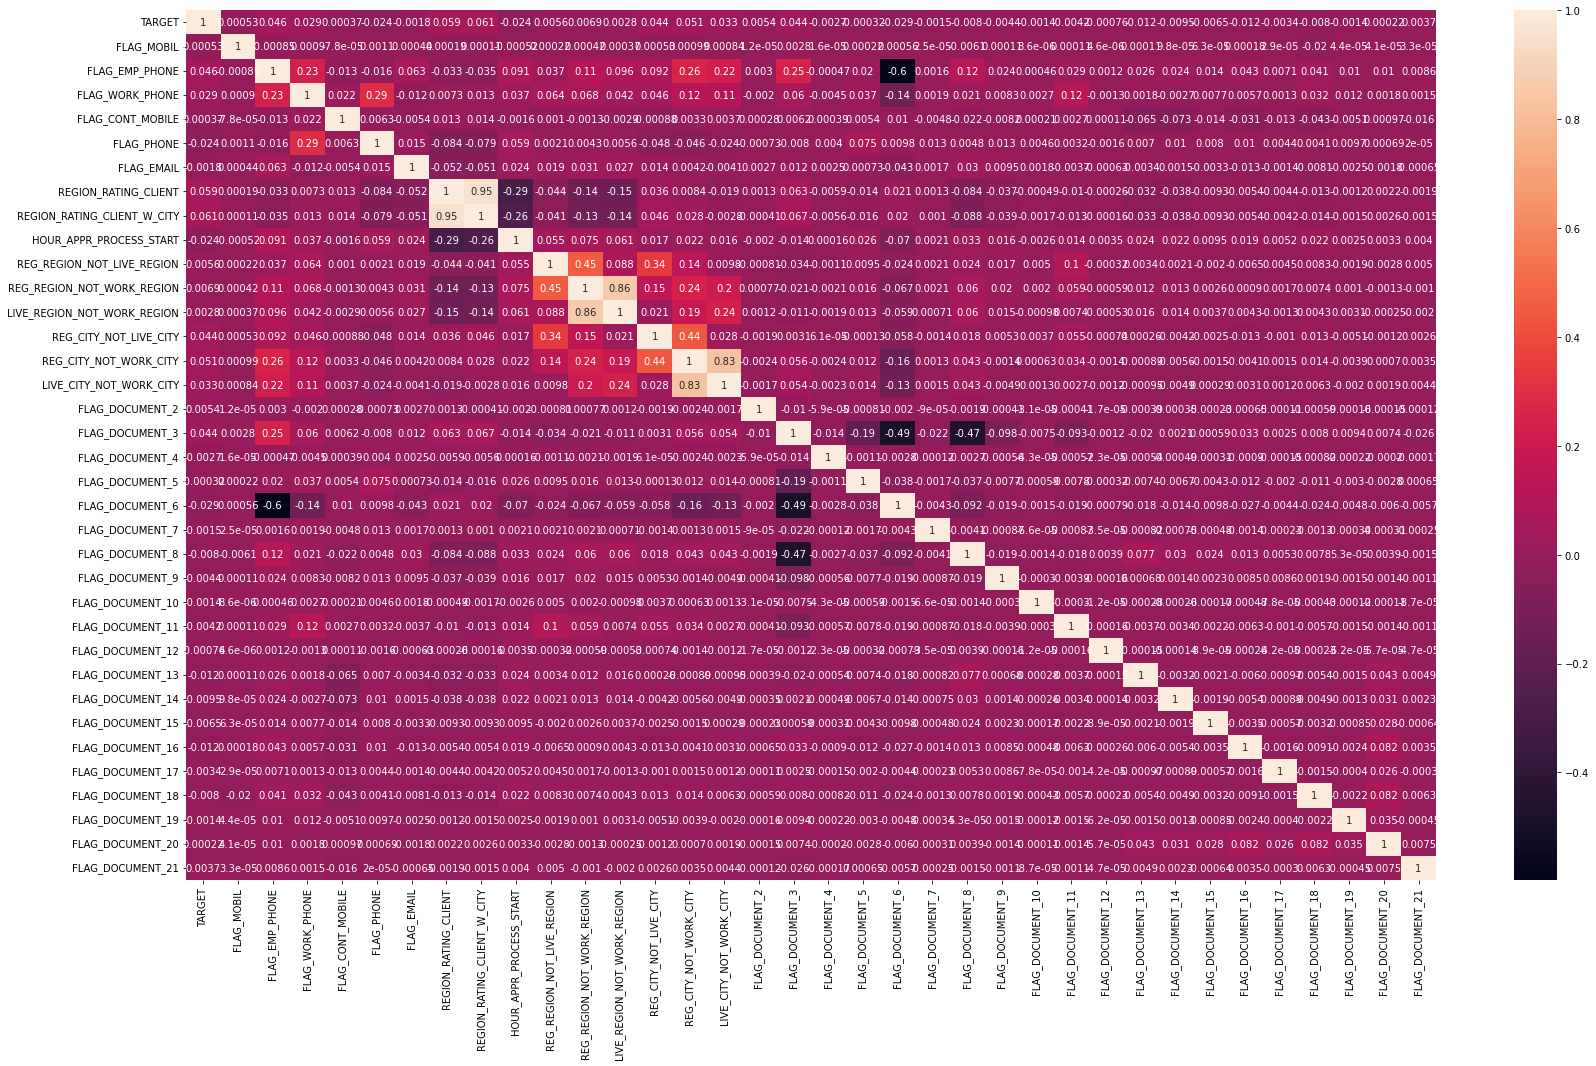

In [104]:
plt.figure(figsize=(28,16))
sns.heatmap(df_qual.corr(),annot=True,)

##### TARGETと特に相関が強い変数は無い

### 散布図

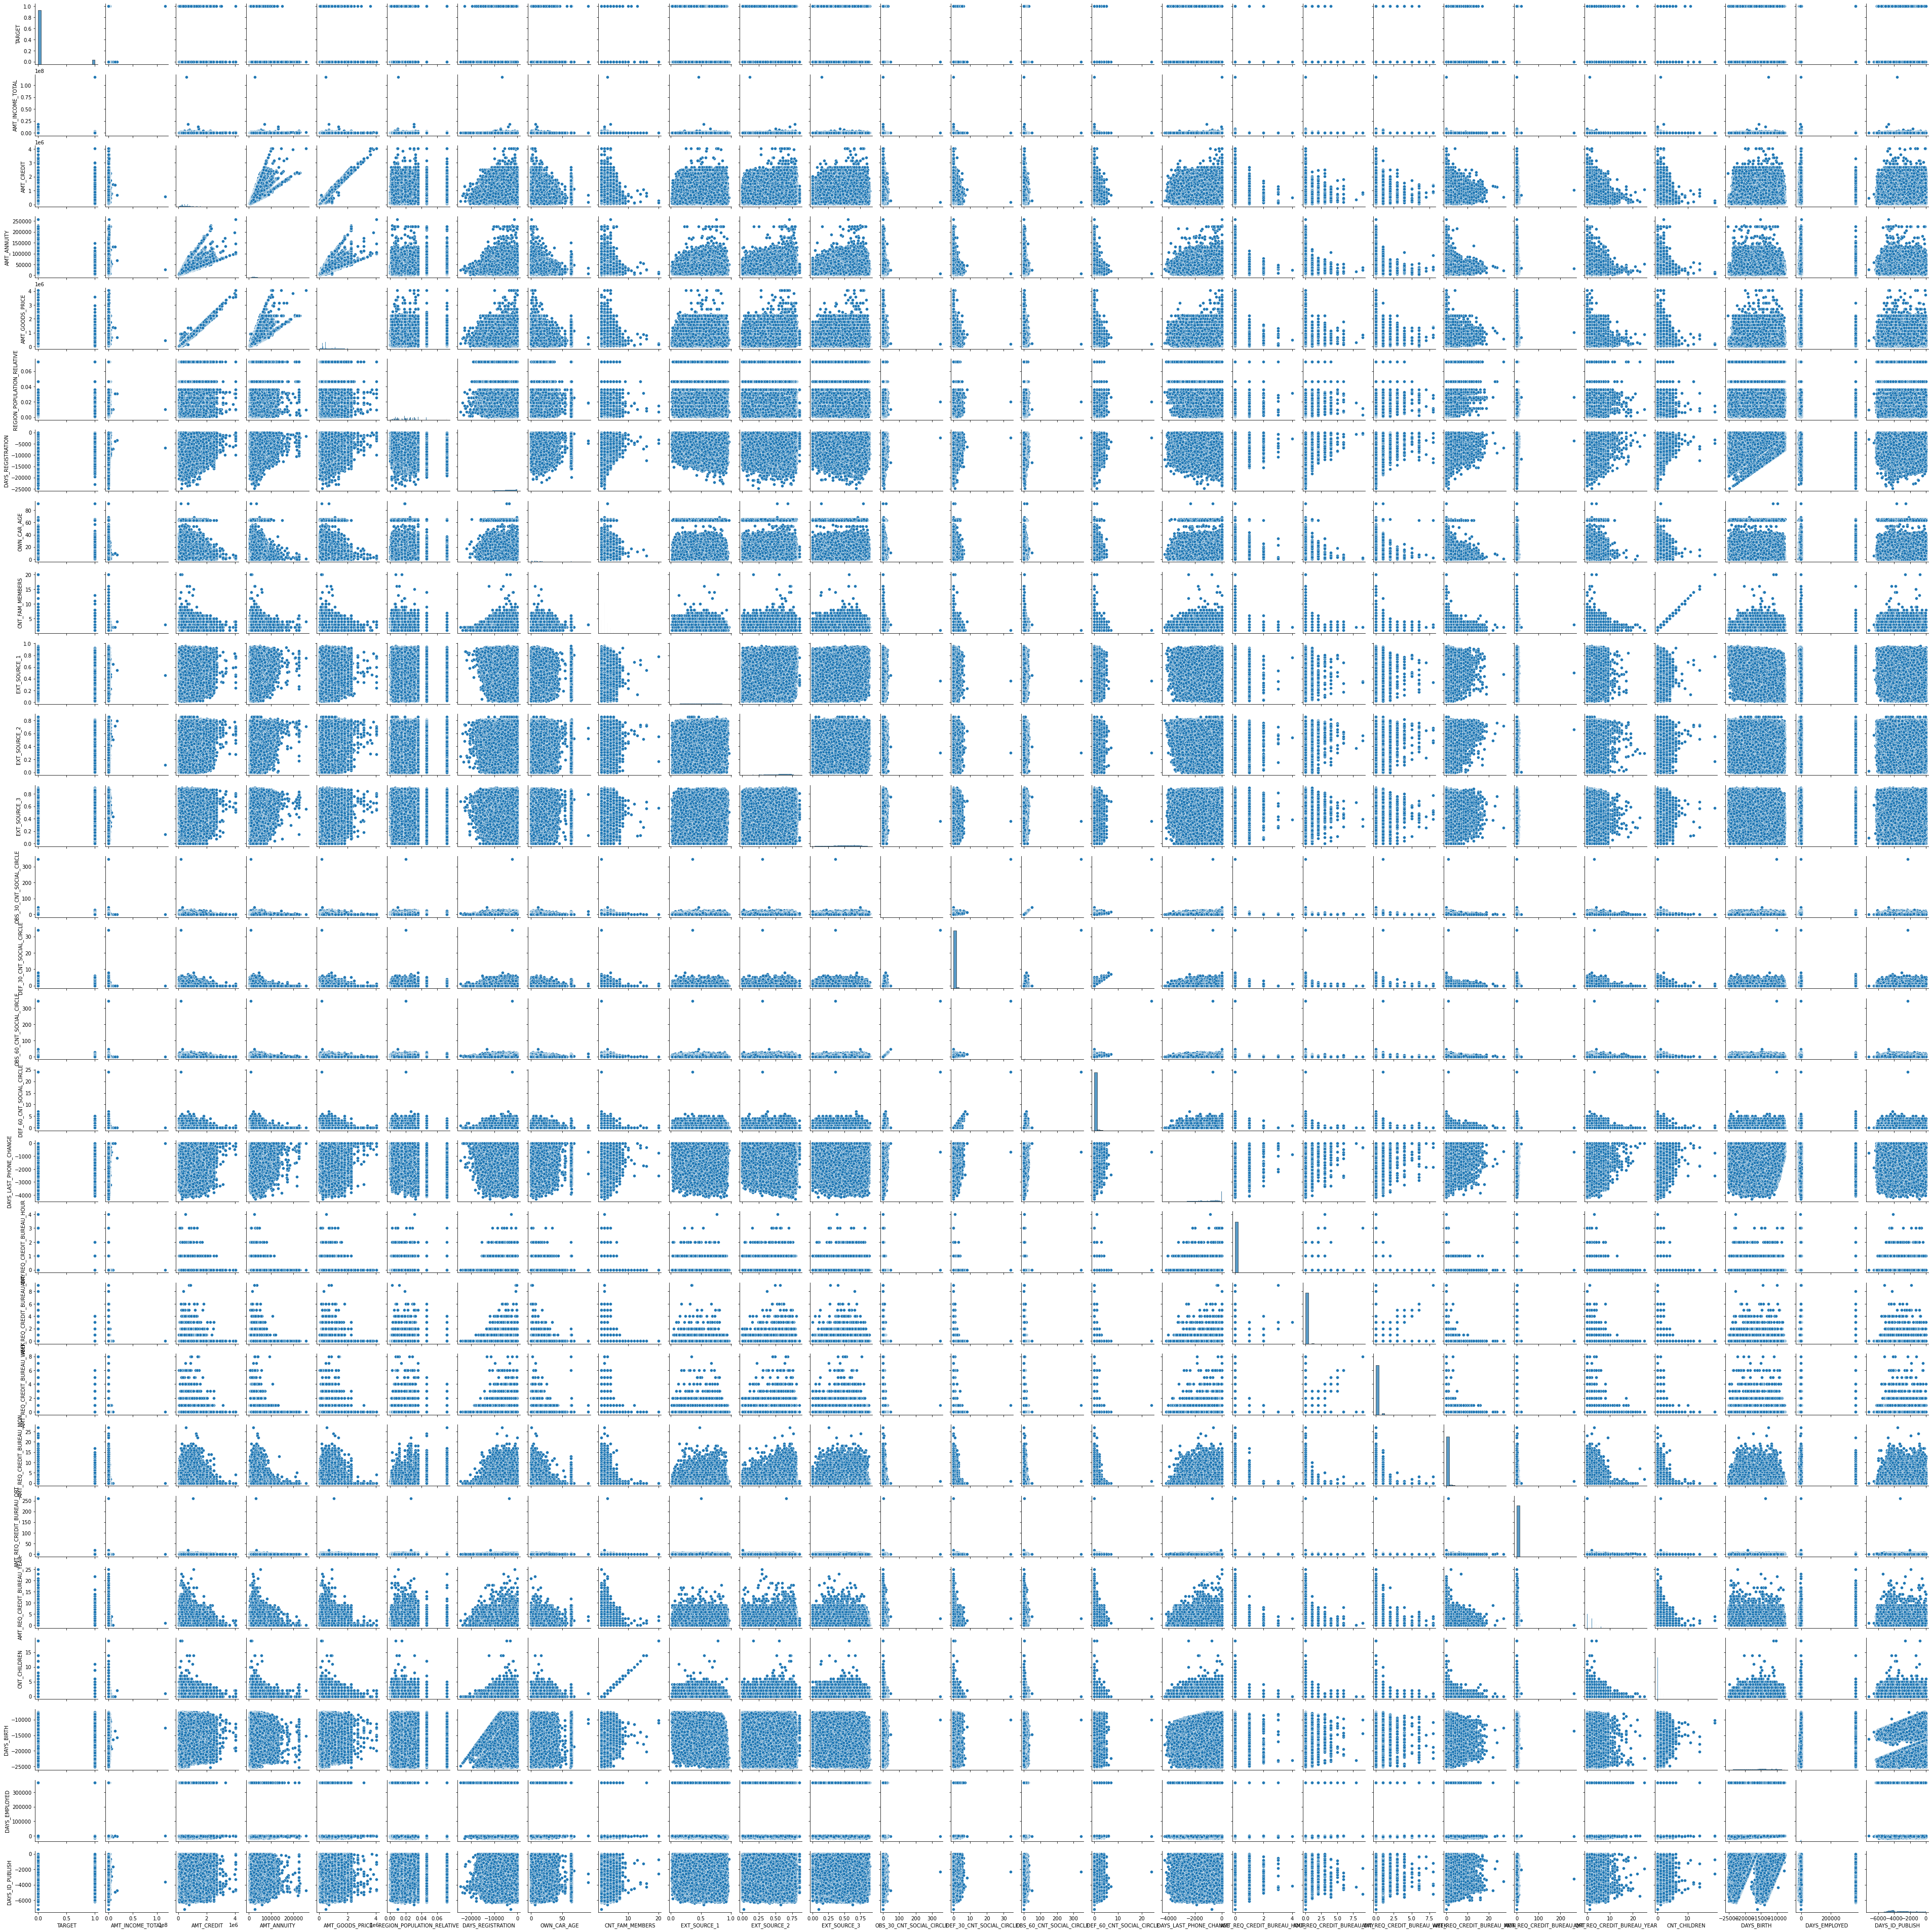

In [105]:
sns.pairplot(df_quant,size=2.0)
plt.show()

##### 外れ値が観測されるが今回は対応しないことに決定した
外れ値もむしろ重要なデータであると考えたためである。

## 欠損値の処理と前処理

In [106]:
#欠損値の数を確認
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False))

OWN_CAR_AGE                   202929
EXT_SOURCE_1                  173378
OCCUPATION_TYPE                96391
EXT_SOURCE_3                   60965
AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_HOUR     41519
NAME_TYPE_SUITE                 1292
DEF_60_CNT_SOCIAL_CIRCLE        1021
DEF_30_CNT_SOCIAL_CIRCLE        1021
OBS_60_CNT_SOCIAL_CIRCLE        1021
OBS_30_CNT_SOCIAL_CIRCLE        1021
EXT_SOURCE_2                     660
AMT_GOODS_PRICE                  278
AMT_ANNUITY                       12
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
dtype: int64


In [107]:
# これらの半数以上が欠損値である変数は使わないこととし、代わりに欠損値である(1)か否(0)かの値を変数として加える
half_drop_cols=["OWN_CAR_AGE","EXT_SOURCE_1"]
half_drop_cols_map={True:1, False:0}
df[half_drop_cols]=df[half_drop_cols].isnull()
df["EXT_SOURCE_1"]=df["EXT_SOURCE_1"].map(half_drop_cols_map)
df["OWN_CAR_AGE"]=df["OWN_CAR_AGE"].map(half_drop_cols_map)

In [108]:
# [DAYS_LAST_PHONE_CHANGE, CNT_FAM_MEMBERS, AMT_ANNUITY, AMT_GOODS_PRICE, EXT_SOURCE_2, DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_30_CNT_SOCIAL_CIRCLE, NAME_TYPE_SUITE]
# これらの変数の欠損値に対しては欠損を含む全ての行の数が全体の1%に満たないため、削除することにする（下のコードで数を確認）=リストワイズ法
drop_cols=["DAYS_LAST_PHONE_CHANGE","CNT_FAM_MEMBERS","AMT_ANNUITY","AMT_GOODS_PRICE","EXT_SOURCE_2","DEF_60_CNT_SOCIAL_CIRCLE",
           "OBS_60_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE", "OBS_30_CNT_SOCIAL_CIRCLE","NAME_TYPE_SUITE"]
df_drop=df[drop_cols]
print(f"欠損を含む行の数:{len(df_drop[df_drop.isnull().any(axis=1)])}")
#削除
df=df.dropna(subset=drop_cols)

欠損を含む行の数:2980


In [109]:
#NAME_EDUCATION_TYPEは順序尺度のためマッピングを行う
education_mapping={"Lower secondary":0, "Secondary / secondary special":1,"Incomplete higher":2,"Higher education":3,"Academic degree":4}
df["NAME_EDUCATION_TYPE"]=df["NAME_EDUCATION_TYPE"].map(education_mapping)

In [110]:
#10%以上が欠損値の変数に対して
#AMTから始まる変数の欠損値は圧倒的に0が多いため、0で埋める
#OCCUPATION_TYPEは欠損値を既存のTYPEに当てはまらなかったと考え、新たにNan-Typeとして埋める
#EXT_SOURCE_3の欠損値は中央値で埋める
df.iloc[:,-6:]=df.iloc[:,-6:].fillna(0)
df["OCCUPATION_TYPE"]=df["OCCUPATION_TYPE"].fillna("Nan-Type")
df["EXT_SOURCE_3"]=df["EXT_SOURCE_3"].fillna(df["EXT_SOURCE_3"].median())

In [111]:
#NAME_HOUSING_TYPEは6つの値が存在するのでOne-Hot-Encodingを行う
df_dummie=pd.get_dummies(df["NAME_HOUSING_TYPE"])
del(df["NAME_HOUSING_TYPE"])
df=pd.concat([df,df_dummie],axis=1)

In [112]:
#その他のobject型の変数は2値のみを持つので0と1を当てはめる
LE=LabelEncoder()
df_obj=df.select_dtypes(include=object)
for col in df_obj.columns:
    df_obj[col] = LE.fit_transform(df_obj[col])
    df[col]=df_obj[col]
df.dtypes.value_counts()

int64      54
float64    20
uint8       6
dtype: int64

### 特徴量エンジニアリング
個人的に重要であると考えた特徴量についてデータから変数を作成し、データフレームに加えていく。

### ① 提出書類
提出書類の総数を特徴量として追加

In [113]:
#FLAG_のみを抽出
df_flag=df.iloc[:,-32:-12]
#FLAG-を合計して新たな特徴量（提出書類の総数）を作成
df_flag["FLAG_DOCUMENT_SUM"]=df_flag.sum(axis=1)
#dfにFLAG_DOCUMENT_SUMを付け足す。
df["FLAG_DOCUMENT_SUM"]=df_flag["FLAG_DOCUMENT_SUM"]

### ②　信用機関への問い合わせ
問い合わせの総数を特徴量として追加する

In [114]:
#AMTのみのデータフレームを作成
df_amt=df.iloc[:,-13:-7]
#AMT-を合計して新たな変数（総数）を作成
df_amt["AMT_REQ_CREDIT_BREAU_SUM"]=df_amt.sum(axis=1)
#dfにAMT_REQ_CREDIT_BREAU_SUMを付け足す。
df["AMT_REQ_CREDIT_BREAU_SUM"]=df_amt["AMT_REQ_CREDIT_BREAU_SUM"]

### ③ 以前の情報
顧客が以前申請したかの情報をprevious_data.csvから得る

In [115]:
df["PREVIOUS"]=df["SK_ID_CURR"].isin(pre_df["SK_ID_CURR"].values)
previous_map={True:1,False:0}
df["PREVIOUS"]=df["PREVIOUS"].map(previous_map)
count=collections.Counter(pre_df["SK_ID_CURR"].sort_values())
df["PREVIOUS_COUNT"]=df["SK_ID_CURR"].map(count)

### ④ 収入/ローン,年金/ローン
ローンに対する家計に入ってくるお金の割合を特徴量として追加する

In [116]:
df["INCOME/LOAN"]=df["AMT_INCOME_TOTAL"]/df["AMT_CREDIT"]
df["ANNUITY/CREDIT"]=df["AMT_ANNUITY"]/df["AMT_CREDIT"]

## 変数の設定(特徴量選択)

In [117]:
#変数の決定
dropcols=["TARGET","SK_ID_CURR"]
X = df.drop(dropcols,axis=1)#目的変数とIDを除く
y = df["TARGET"]#目的変数

#データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.dtypes.value_counts()

int64      55
float64    23
uint8       6
dtype: int64

### 相互情報量を用いて17変数を選択する（Filter法）
パレートの法則から、20%の変数が目的変数を説明する変数全体の80%を構成すると考えた。

現在84変数あり、その20%つまり17変数を用いることとする。

またFilter法に用いた評価指標は、確率変数の間の「依存度」を表す指標の相互情報量(mutual information)である。

$$相互情報量I(X;Y)=\int_{}^{} \int_{}^{}{P_(x,y)\ln{\frac{P(x,y)}{P(x)P(y)}}}dxdy$$
$$P(x,y)：同時確率,　P(x),P(y)：確率変数$$


In [118]:
mic=mutual_info_classif(X_train,y_train,n_neighbors=3,random_state=0)
miscores=pd.DataFrame(mic).T
miscores.columns=X_train.columns
miscores=miscores.T.nlargest(17,0)
miscores

0
FLAG_MOBIL                   0.052344
FLAG_CONT_MOBILE             0.051114
PREVIOUS                     0.046961
House / apartment            0.040657
FLAG_DOCUMENT_SUM            0.040435
FLAG_EMP_PHONE               0.035551
NAME_TYPE_SUITE              0.033716
REGION_RATING_CLIENT_W_CITY  0.032417
REGION_RATING_CLIENT         0.030757
FLAG_DOCUMENT_3              0.026409
NAME_EDUCATION_TYPE          0.024527
FLAG_OWN_REALTY              0.024307
OWN_CAR_AGE                  0.022718
ANNUITY/CREDIT               0.018242
NAME_INCOME_TYPE             0.018164
NAME_FAMILY_STATUS           0.017516
CNT_FAM_MEMBERS              0.016704

In [119]:
X_train=X_train[miscores.T.columns]
X_test=X_test[miscores.T.columns]

### 有用であると予想して作成した特徴量のうち「信用機関の問い合わせ総数」と「以前の情報の数」,「収入/ローン」は目的変数との依存度が低いと判断された
### 質的変数がやや多い結果となった

## 問題構造の可視化
特徴量抽出（PCA）によって問題構造を可視化する

In [120]:
scaler=StandardScaler()
X_std = scaler.fit_transform(X_train)#標準化
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)#２次元に削減
pca.explained_variance_ratio_

array([0.12835642, 0.11576537, 0.09396083])

約30%だが問題構造を見るには十分

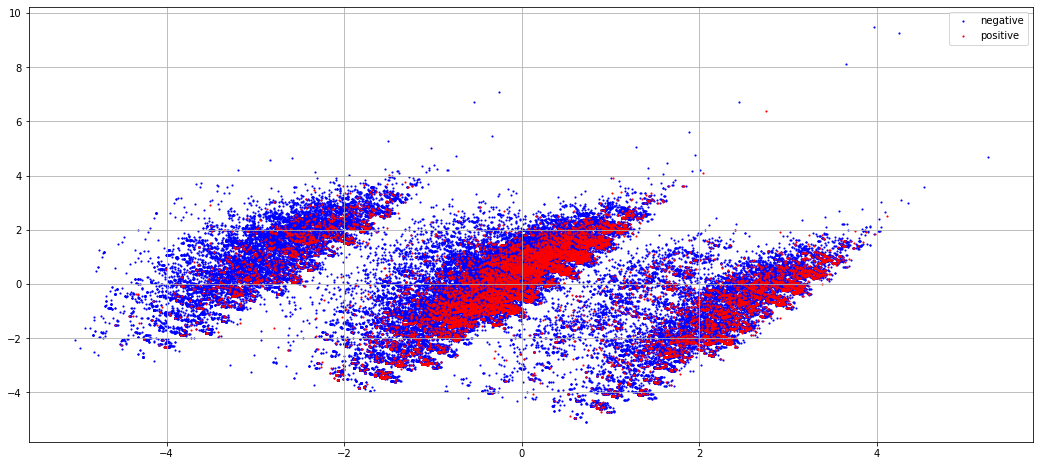

In [121]:
#2次元空間
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.scatter(X_pca[y_train.values.reshape(-1)==0,0],
            X_pca[y_train.values.reshape(-1)==0,1],
              s = 5,
              color=(0, 0, 1, 1),
              marker='.',
              label='negative')
ax.scatter(X_pca[y_train.values.reshape(-1)==1,0],
            X_pca[y_train.values.reshape(-1)==1,1],
             s = 5,
              color='r',
              marker='.',
              label='positive')

ax.legend()
ax.grid()

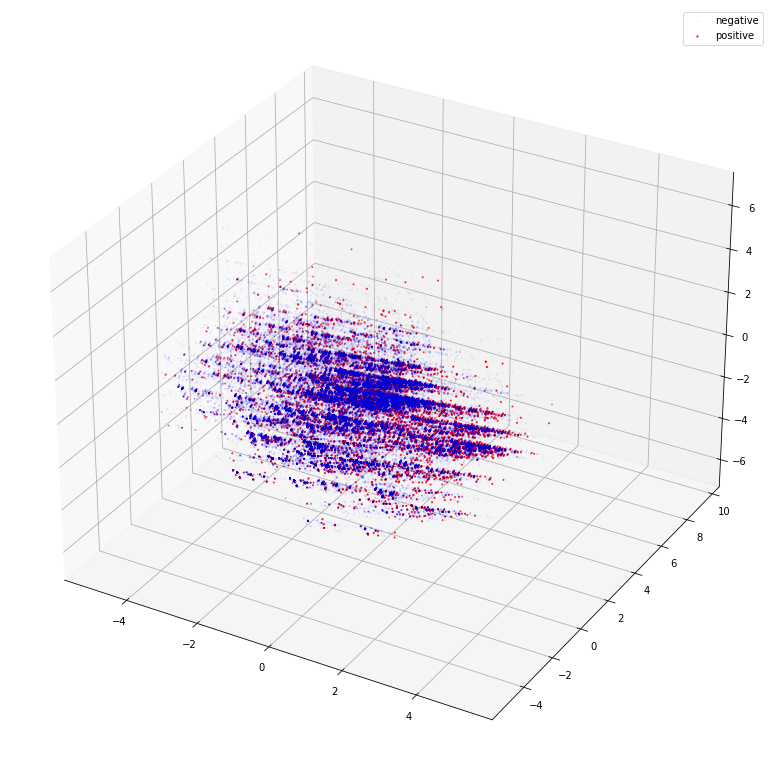

In [122]:
#３次元空間
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_pca[y_train.values.reshape(-1)==0,0],
            X_pca[y_train.values.reshape(-1)==0,1],
            X_pca[y_train.values.reshape(-1)==0,2],
              s = 5,
              color=(0, 0, 1, 0.05),
              marker='.',
              label='negative')
ax.scatter(X_pca[y_train.values.reshape(-1)==1,0],
            X_pca[y_train.values.reshape(-1)==1,1],
            X_pca[y_train.values.reshape(-1)==1,2],
             s = 5,
              color=(1, 0, 0, 1),
              marker='.',
              label='positive')

ax.legend()
ax.grid()

#### ・線形分離は不可能であると思われる(ロジスティック回帰,SVM等単純な線形モデルでは予測精度が悪いと考えられる)

→決定木系のモデルを軸に見ていくこととする

## モデルの作成
・層化5分割交差検証を行う
・不均衡データであるため、SMOTEによるオーバーサンプリングを交差検証の中で行う

参考

Santos, M. S., Soares, J. P., Abreu, P. H., Araujo, H., & Santos, J. (2018). Cross-validation for imbalanced datasets: avoiding overoptimistic and overfitting approaches [research frontier]. ieee ComputatioNal iNtelligeNCe magaziNe, 13(4), 59-76.


In [123]:
#学習と評価をする関数を作成(層化K分割交差検証)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
smote = SMOTE(sampling_strategy=0.8,random_state=0)

def learn_eval(model):
    f2_scores=[]
    logloss_scores=[]
    accuracy_scores=[]
    precision_scores=[]
    recall_scores=[]
    for tr_idx, va_idx in kf.split(X_train,y_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
        #SMOTEでオーバーサンプリング
        res_x, res_y = smote.fit_resample(tr_x, tr_y)
        #モデルで学習
        model=model
        model.fit(res_x, res_y)
        #予測
        va_pred=model.predict(va_x)
        #評価
        f2=metrics.fbeta_score(va_y,va_pred,beta=2)
        f2_scores.append(f2)

        log_loss_score=metrics.log_loss(va_y,va_pred)
        logloss_scores.append(log_loss_score)

        accuracy_score=metrics.accuracy_score(va_y,va_pred)
        accuracy_scores.append(accuracy_score)

        precision_score=metrics.precision_score(va_y,va_pred)
        precision_scores.append(precision_score)

        recall_score=metrics.recall_score(va_y,va_pred)
        recall_scores.append(recall_score)
     #評価表示
    print('f2スコア: {:.3f}'.format(np.mean(f2_scores)))
    print('log_loss: {:.3f}'.format(np.mean(logloss_scores)))
    print("------------------------")
    print('正答率: {:.3f}'.format(np.mean(accuracy_scores)))
    print('適合率: {:.3f}'.format(np.mean(precision_scores)))
    print('再現率: {:.3f}'.format(np.mean(recall_scores)))

#### 以下のハイパーパラメータに関しては、loglossが最小になるようにベイズ最適化（TPE）を用いたOputunaで得たものである

In [124]:
params_best_rf={'n_estimators': 4, 'max_depth': 112, 'random_state': 0}
params_best_dt={'min_samples_split': 294, 'min_samples_leaf': 12, 'max_depth': 133, 'random_state': 0}
params_best_xgb={'n_estimators': 62, 'learning_rate': 0.27187519175544705, 'random_state': 0,'eval_metric':'logloss'}
params_best_lgb={'num_leaves': 91, 'min_child_samples': 2, 'max_depth': 125, 'random_seed': 0}

### 各モデルの検証データにおける評価

冒頭でも記述したようにF2Scoreがメインの評価指標であり重視するが、loglossの値も参考に評価を見ていく。

In [125]:
learn_eval(RandomForestClassifier(**params_best_rf))

f2スコア: 0.188
log_loss: 7.080
------------------------
正答率: 0.795
適合率: 0.113
再現率: 0.225


In [126]:
learn_eval(DecisionTreeClassifier(**params_best_dt))

f2スコア: 0.236
log_loss: 7.686
------------------------
正答率: 0.777
適合率: 0.127
再現率: 0.300


In [127]:
learn_eval(xgb.XGBClassifier(**params_best_xgb))

f2スコア: 0.291
log_loss: 7.438
------------------------
正答率: 0.785
適合率: 0.155
再現率: 0.373


In [128]:
learn_eval(lgb.LGBMClassifier(**params_best_lgb))

f2スコア: 0.301
log_loss: 8.378
------------------------
正答率: 0.757
適合率: 0.146
再現率: 0.411


In [129]:
learn_eval(GaussianNB())

f2スコア: 0.318
log_loss: 14.862
------------------------
正答率: 0.570
適合率: 0.109
再現率: 0.606


GaussianNBが最もF2スコアが高いがloglossは高く精度が悪い
二番目にF2スコアが高いLightGBMはloglossもそこまで低くなくバランスが良いと判断できる。

よってアンサンブルモデルではLightGBMに2倍、GaussianNBに0.6倍の比重を置いた加重平均とする

## 提案するアンサンブルモデルの評価

In [130]:
learn_eval(VotingClassifier(estimators=[('rf', RandomForestClassifier(max_depth=10,n_estimators=50)),
                                        ('rf_d', RandomForestClassifier(max_depth=20,n_estimators=100)),
                                        ('xgb',xgb.XGBClassifier(**params_best_xgb)),
                                        ('lgb',lgb.LGBMClassifier(**params_best_lgb)),
                                        ('gnb',GaussianNB())],
                                        weights=[1,1,1,2,0.6],
                                        voting="soft"))

f2スコア: 0.310
log_loss: 8.275
------------------------
正答率: 0.760
適合率: 0.150
再現率: 0.422


## 再学習（最終的なモデル）

提案するモデルが最も精度の良かったので再学習を行い、テストデータの予測を行う

In [131]:
best_model=VotingClassifier(estimators=[('rf', RandomForestClassifier(max_depth=10,n_estimators=50)),
                                        ('rf_d', RandomForestClassifier(max_depth=20,n_estimators=100)),
                                        ('xgb',xgb.XGBClassifier(**params_best_xgb)),
                                        ('lgb',lgb.LGBMClassifier(**params_best_lgb)),
                                        ('gnb',GaussianNB())],
                                        weights=[1,1,1,2,0.6],
                                        voting="soft")
X_res, y_res = smote.fit_resample(X_train, y_train)
best_model.fit(X_res, y_res)
last_pred=best_model.predict(X_test)

### 最終評価

In [132]:
#評価表示
print('f2スコア: {:.3f}'.format(metrics.fbeta_score(y_test,last_pred,beta=2)))
print('log_loss: {:.3f}'.format(metrics.log_loss(y_test,last_pred)))
print("------------------------")
print('正答率: {:.3f}'.format(metrics.accuracy_score(y_test,last_pred)))
print('適合率: {:.3f}'.format(metrics.precision_score(y_test,last_pred)))
print('再現率: {:.3f}'.format(metrics.recall_score(y_test,last_pred)))

f2スコア: 0.308
log_loss: 8.316
------------------------
正答率: 0.759
適合率: 0.150
再現率: 0.418


#### 検証の結果とあまり変わらないため、このデータにおいては汎用性の高いモデルと言える。

In [133]:
# 混合行列を表示
labels = [0, 1]
cm=confusion_matrix(y_test,last_pred,labels=labels)
columns_labels = ["pred_" + str(l) for l in labels]
index_labels = ["act_" + str(l) for l in labels]
cm = pd.DataFrame(cm,columns=columns_labels, index=index_labels)
cm

pred_0  pred_1
act_0   44161   11765
act_1    2900    2081

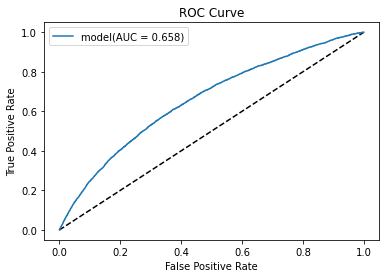

In [134]:
# ROC曲線を出力
y_pred_proba=best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,)
# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='model(AUC = %0.3f)' % metrics.roc_auc_score(y_test, y_pred_proba))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

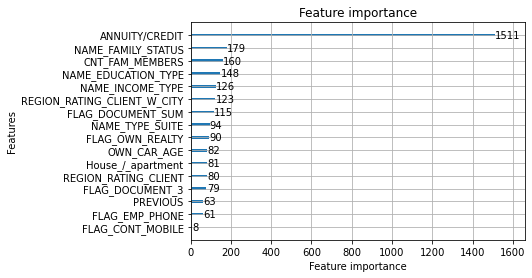

In [135]:
#FeatureImportance(決定木に出現する変数の頻度)の出力
model_lgb=lgb.LGBMClassifier().fit(X_train,y_train)
lgb.plot_importance(model_lgb)

圧倒的に年金/ローンが多く決定木の中に登場したため、重要な変数であると思われる。
しかし、他の変数の出現頻度との差が非常に大きい。それだけこの変数が重要である可能性もあるが多くの変数を特徴量選択の際に落としていることから、相互情報量だけでは重要な変数が選択されきれないと考えられる。
この点で特徴量選択での改善の余地があると思われる。

In [136]:
#SMOTEの効果検証
best_model.fit(X_train, y_train)
last_pred_smote=best_model.predict(X_test)
#評価表示
print('f2スコア: {:.3f}'.format(metrics.fbeta_score(y_test,last_pred_smote,beta=2)))
print('log_loss: {:.3f}'.format(metrics.log_loss(y_test,last_pred_smote)))
print("------------------------")
print('正答率: {:.3f}'.format(metrics.accuracy_score(y_test,last_pred_smote)))
print('適合率: {:.3f}'.format(metrics.precision_score(y_test,last_pred_smote)))
print('再現率: {:.3f}'.format(metrics.recall_score(y_test,last_pred_smote)))

f2スコア: 0.000
log_loss: 2.825
------------------------
正答率: 0.918
適合率: 0.500
再現率: 0.000


smoteが有効であることが示された。